In [15]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [42]:
import math
import os
import time


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product

from scipy.stats import pearsonr
from importlib import reload

from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch_new
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch_new)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange
from lib.pacha_sketch_new import PachaSketch, ADTree, BFParameters, CMParameters, build_pacha_sketch_uniform_size, \
    build_pacha_sketch_from_json_file

from lib.ploting import set_style, plot_ylabel, plot_legend

# set_style()

# Playground Export and Import Pacha Sketch

In [43]:
ad_tree = ADTree()
ad_tree.add_dimension({"m","f","d"})
ad_tree.add_dimension({"Baden-Württemberg", "Bavaria", "Berlin", "Brandenburg", "Bremen", 
        "Hamburg", "Hesse", "Lower Saxony", "Mecklenburg-Vorpommern", 
        "North Rhine-Westphalia", "Rhineland-Palatinate", "Saarland", 
        "Saxony", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"
    })
ad_tree.add_dimension({chr(i) for i in range(97, 123)})

In [5]:
input_data = pd.read_parquet("data/clean/paper_example_200k.parquet")

In [6]:
pacha_sketch = build_pacha_sketch_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[1,0,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=0.01, eps=0.00005),
    bf_params=BFParameters(p=0.0001, n_values=200000),
    cat_index_parameters=BFParameters(p=0.0001, n_values=4*200000),
    num_index_parameters=BFParameters(p=0.0001, n_values=10*200000),
    n_sparse_levels=2)

In [53]:
pacha_sketch = build_pacha_sketch_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[1,0,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(width=10,depth=3),
    bf_params=BFParameters(size=10, hash_count=3),
    cat_index_parameters=BFParameters(size=10, hash_count=3),
    num_index_parameters=BFParameters(size=10, hash_count=3),
    n_sparse_levels=1)

In [11]:
from pympler import asizeof
print(asizeof.asizeof(pacha_sketch)/1024/1024, "MB")

0.01668548583984375 MB


In [55]:
pacha_sketch.update_data_frame(input_data.head(1), workers=os.cpu_count())

Updating: 100%|██████████| 1/1 [00:00<00:00, 3615.78it/s]


In [25]:
pacha_sketch.save_to_file("sketches/paper_example_200k.json.gz")

In [78]:
pacha_sketch2 = build_pacha_sketch_from_json_file("sketches/paper_example_200k.json.gz")

In [69]:
pacha_sketch == pacha_sketch2

True

In [79]:
pacha_sketch2.query(["*", {"m"}, "*", "*", (0, 100), (30, 40)], debug=True)

Categorical regions: 1
Indexed categorical regions: 1
Numerical regions: 13727
Indexed numerical regions: 231
Query regions: 231
Level 0 queries: 137
Level 1 queries: 83
Level 3 queries: 11


np.int64(6701)

In [54]:
filtered_data = input_data[
    (input_data['gender'] == 'm') & 
    (input_data['total'] >= 0) & (input_data['total'] <= 100) & 
    (input_data['age'] >= 30) & (input_data['age'] <= 40)
]

count = len(filtered_data)
print("Count:", count)

Count: 3263


In [11]:
bit_array = np.zeros(10, dtype=bool)
bit_array

array([False, False, False, False, False, False, False, False, False,
       False])

In [36]:
bf = BloomFilter(hash_count=3, size=10, diff_privacy=10)

In [37]:
bf.bit_array

array([False, False, False, False, False, False, False, False, False,
       False])

In [5]:
diff_privacy = 1.0  # Set your desired differential privacy parameter here

noise = np.random.laplace(loc=0.0, scale=1/diff_privacy, size=counters.shape)
counters_noisy = counters + noise
print(counters_noisy)

[[ 6.63159991 -0.26027534  0.16683124  0.08972531  0.42984374 -0.10229674
  -0.09912537 -0.24049725  1.0326134  -1.06121831]
 [-0.50781722  1.40199097  0.65729241  0.45201784  0.61299207 -0.58389718
  -0.08472607  0.12234823 -1.43033034 -0.3300511 ]
 [-0.56999084  2.49500294 -0.12330253 -0.40619295  0.32434932  1.1885241
  -1.50645273  0.8759689   1.26800276 -0.48504461]]


In [10]:
counters_noisy_rounded = np.round(noise).astype(int)
print(counters_noisy_rounded)

[[ 7  0  0  0  0  0  0  0  1 -1]
 [-1  1  1  0  1 -1  0  0 -1  0]
 [-1  2  0  0  0  1 -2  1  1  0]]


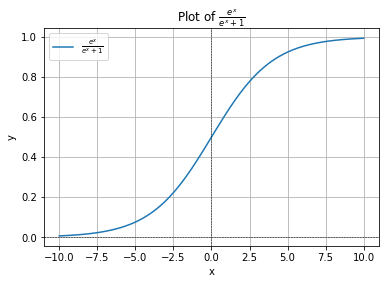

In [7]:
x = np.linspace(-10, 10, 500)  # Generate 500 points between -10 and 10
y = np.exp(x/2) / (np.exp(x/2) + 1)  # Compute the function

plt.plot(x, y, label=r"$\frac{e^x}{e^x + 1}$")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of $\\frac{e^x}{e^x + 1}$")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [6]:
1 / (np.exp(10) + 1) 

np.float64(4.5397868702434395e-05)

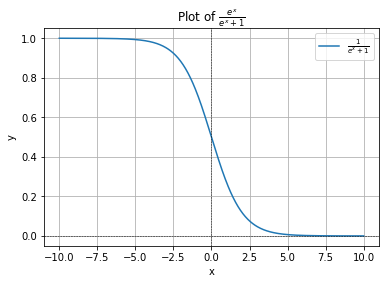

In [4]:
x = np.linspace(-10, 10, 500)  # Generate 500 points between -10 and 10
y = 1 / (np.exp(x) + 1)  # Compute the function

plt.plot(x, y, label=r"$\frac{1}{e^x + 1}$")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of $\\frac{e^x}{e^x + 1}$")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid()
plt.show()